# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [ ]:
# Create a function for reading the dataset and splitting into training and testing sets with scaled and unscaled data
def load_data(path):
    df = pd.read_csv(path)
    # check if the dataset has been loaded properly
    if df.empty:
        raise ValueError("the dataset is empty, please check the path or the file content.")
    print(f"loaded dataset with shape: {df.shape}")

    # Split the data into features and target variables
    X = df.drop(columns=['taxvaluedollarcnt'])
    y = df['taxvaluedollarcnt']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # create scaled versions of the train and test features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df

In [3]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df = load_data('Milestone Data/zillow_cleaned.csv')

loaded dataset with shape: (71217, 25)


### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [4]:
def run_model(model, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=random_state, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_rmse_scores = cross_val_score(model, X_train, y_train, scoring = 'neg_root_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state), n_jobs = n_jobs)
    
    mean_cv_rmse = -np.mean(neg_rmse_scores)
    std_cv_rmse  = np.std(neg_rmse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training RMSE
    train_preds = model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, train_preds)
    
    return mean_cv_rmse, std_cv_rmse, train_rmse

In [5]:
model_dict = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

In [ ]:
# Create a function that runs all the models and returns a Dataframe with the results
def evaluate_model(dict, x_train, y_train, random_state=random_state):
    results = {}
    for model_name, model in dict.items():
        print(f"Evaluating {model_name}...")
        mean_cv_rmse, std_cv_rmse, train_rmse = run_model(model, x_train, y_train, random_state=random_state)
        results[model_name] = {
            'Mean CV RMSE': dollar_format(mean_cv_rmse, 2),
            'STD CV RMSE': dollar_format(std_cv_rmse, 2),
            'Train CV RMSE': dollar_format(train_rmse, 2)
        }
    
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Model'
    results_df = results_df.sort_values(by='Mean CV RMSE', ascending=True)
    print("Evaluation complete. Results:")
    return results_df

In [19]:
raw_features = evaluate_model(model_dict, X_train, y_train, random_state=random_state)
print("================================")
raw_features

Evaluating Linear...
Evaluating Ridge...
Evaluating Lasso...
Evaluating Decision Tree...
Evaluating Bagging...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluation complete. Results:


,Mean CV RMSE,STD CV RMSE,Train CV RMSE
Model,,,
Random Forest,"$241,673","$2,345","$92,191"
Gradient Boosting,"$245,812","$2,737","$242,356"
Bagging,"$251,809","$2,616","$106,669"
Linear,"$276,212","$2,985","$276,019"
Ridge,"$276,212","$2,985","$276,019"
Lasso,"$276,212","$2,985","$276,019"
Decision Tree,"$332,627","$3,862","$24,216"


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

** Answers **
* The top 3 best performing models were the Random Forest, Gradient Boosting, and Bagging tree models. Random Forest was best overall with top 2 marks in all measurements with the best Mean CV RMSE of $241,624 
* The top 3 most stable models are the same top 3 performers, Bagging, Random Forest, Gradient Boosting. Bagging was the most stable with a standard deviation of $2,394
* The Decision Tree regressor might have been subject to overfitting as it's training rmse was very low, almost to the point of an optimized model, and it's Mean CV RMSE was very high compared to the rest. The Linear, Ridge, and Lasso models seemed to underfit the model because their training rmse values were almost identical to their Mean CV rmse scores.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [8]:
# Standard Scaler for large variance numberic features
def standardized(df, column):
  scaler = StandardScaler()
  df[f'{column}_standardized'] = scaler.fit_transform(df[[column]])
  fig, axes = plt.subplots(1,2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_standardized'])
  axes[1].set_title(f'standardized {column}')

In [9]:
# log transfer
def log_transformation(df, column):
  df[f'{column}_log_transformed'] = np.log(df[column])
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_log_transformed'])
  axes[1].set_title(f'log transformed {column}')

In [10]:
# polynomial for calculatedbathnbr
def polynomial_transformation(df, column, degree):
  df[f'{column}_poly_transformed'] = df[column]**degree
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_poly_transformed'])
  axes[1].set_title(f'poly transformed {column}')

In [11]:
pd.set_option('display.max_columns', None)
df_transformations = df.copy()
df_transformations.head()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,garagecarcnt,garageunknown,hashottuborspa,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxdelinquencyflag,taxvaluedollarcnt
0,0.0,3.5,4.0,8.0,3.5,3100.0,3100.0,0.0,3.0,2.0,0,False,2.0,4506.0,0.0,261.0,53571.0,1286.0,48570.0,96978.0,0.0,0.0,1998.0,False,1023282.0
1,0.0,1.0,2.0,8.0,1.0,1465.0,1465.0,1.0,1.0,1.0,0,False,2.0,12647.0,0.0,261.0,13091.0,2061.0,48570.0,97099.0,5.0,0.0,1967.0,False,464000.0
2,0.0,2.0,3.0,8.0,2.0,1243.0,1243.0,0.0,2.0,2.0,0,False,2.0,8432.0,1.0,261.0,21412.0,1286.0,48570.0,97078.0,6.0,0.0,1962.0,False,564778.0
3,0.0,3.0,4.0,8.0,3.0,2376.0,2376.0,0.0,3.0,0.0,1,False,2.0,13038.0,1.0,261.0,396551.0,3101.0,48570.0,96330.0,0.0,1.0,1970.0,False,145143.0
4,0.0,3.0,3.0,8.0,3.0,1312.0,1312.0,0.0,3.0,0.0,1,False,2.0,278581.0,1.0,266.0,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,False,119407.0


In [12]:
# Split the df_transofrmation data into features and target variables
X_t = df_transformations.drop(columns=['taxvaluedollarcnt'])
y_t = df_transformations['taxvaluedollarcnt']

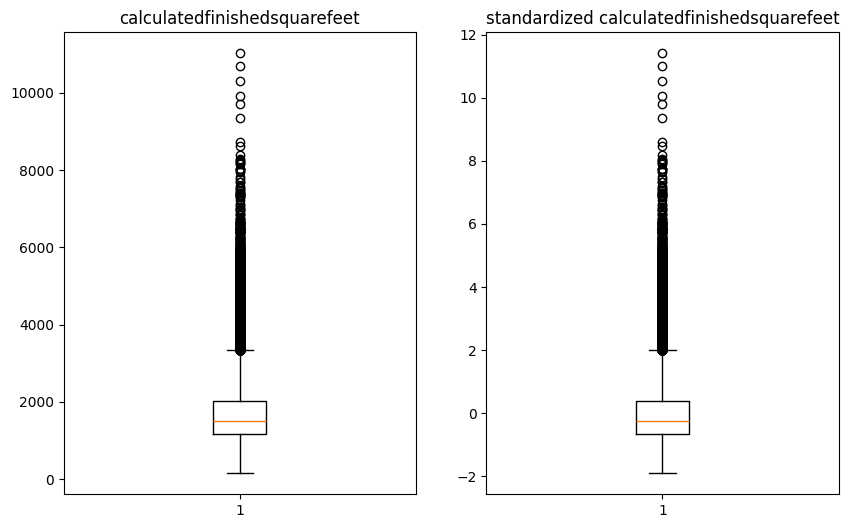

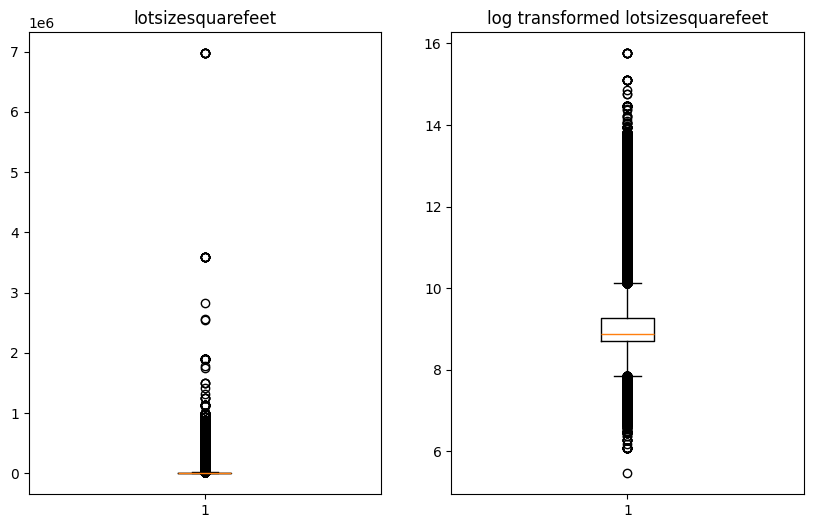

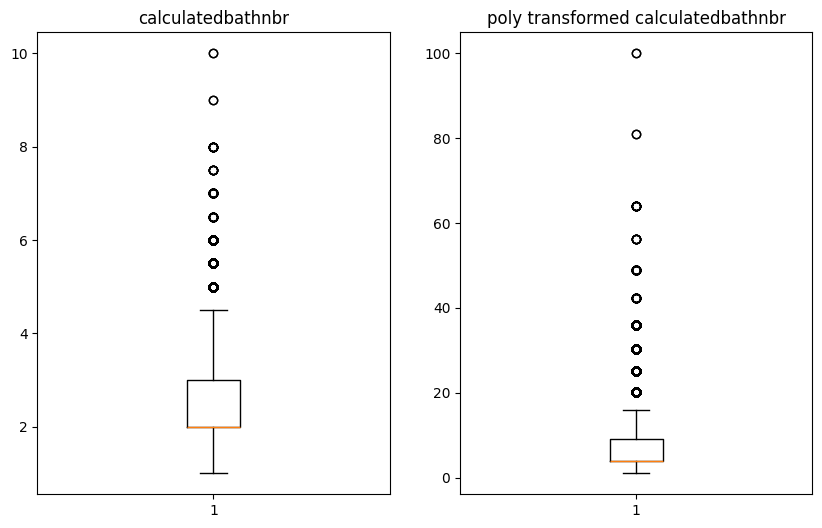

In [13]:
# transform features using the defined funcitons
standardized(X_t, 'calculatedfinishedsquarefeet')

log_transformation(X_t, 'lotsizesquarefeet')

polynomial_transformation(X_t, 'calculatedbathnbr', 2)

In [14]:
# drop the original columns after transformation
X_t = X_t.drop(columns=['calculatedfinishedsquarefeet','lotsizesquarefeet','calculatedbathnbr'])

In [15]:
# Standardize the transformed features and split into training and testing sets
scaler_t = StandardScaler()
X_t_scaled = scaler_t.fit_transform(X_t)

X_train_scaled_t, X_test_scaled_t, y_train_t, y_test_t = train_test_split(
    X_t_scaled, y_t, test_size=.2, random_state=random_state
)

In [16]:
# Evaluate the models again with the transformed features
transformed_features = evaluate_model(model_dict, X_train_scaled_t, y_train_t, random_state=random_state)
print("================================")
transformed_features

Evaluating Linear...
Evaluating Ridge...
Evaluating Lasso...
Evaluating Decision Tree...
Evaluating Bagging...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluation complete. Results:


,Mean CV RMSE,STD CV RMSE,Train CV RMSE
Model,,,
Random Forest,"$241,517","$2,488","$91,904"
Gradient Boosting,"$245,810","$2,734","$242,356"
Bagging,"$252,304","$2,431","$107,635"
Linear,"$275,450","$2,983","$275,214"
Ridge,"$275,450","$2,983","$275,214"
Lasso,"$275,450","$2,983","$275,214"
Decision Tree,"$333,088","$3,705","$24,216"


In [17]:
raw_features

,Mean CV RMSE,STD CV RMSE,Train CV RMSE
Model,,,
Random Forest,"$241,729","$2,301","$92,334"
Gradient Boosting,"$245,812","$2,741","$242,356"
Bagging,"$251,979","$2,516","$107,527"
Linear,"$276,212","$2,985","$276,019"
Ridge,"$276,212","$2,985","$276,019"
Lasso,"$276,212","$2,985","$276,019"
Decision Tree,"$332,955","$3,510","$24,216"


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



** Answers **
* No noticeable improvements were made when evaluating models with transformed features, in some cases, models regressed in performance. The Random Forest model which performed the best in all categories had a worse standard deviation after being evaluated on the transformed df.
* Standardizing and Log transforming features seem to have very small improvements no matter the feature. However, Polynomial transformations didn't seem to imporve the forformance of the models/were not affected by the transformation.
* Tree models are relativeley unaffected by scaling features since they preserve the underlying relationship to the target. Since the 3 ensemble models we are evaluating on are tree based they showed little improvement
* The results were somewhat surprising as I was expecting more than negligible differences between the raw vs transformed features.

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> Your text here

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [18]:
# Add as many code cells as you need

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

> Your text here